In [1]:
import librosa
import soundfile
import itertools
from aubio import source, onset
import numpy as np
import math
import os
from os.path import join
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

## Librosa

In [17]:
wav_lst = os.listdir(join('NorthEastUS_Bird_testset'))
# Sampling Rate
sr = 24000
len(wav_lst)

801

In [2]:
### Function of Using LIBROSA for onset detection/counting ###
# file_path: absolute path to the sound clip
# fs: sampling rate
# mode: time-units based onset detect or env-units based onset detect; default='time'
def librosa_onsets(file_path, fs=24000, mode='time'):
    signal, fs = librosa.load(file_path, sr=fs)
    
    if mode == 'time':
        ### wait: gap between peaks; pre/post_max/avg: windowing; delta: threshold ###
        try:
            onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True, 
                                                  wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1, delta=0.2)
        except:
            return np.array([])
        #onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True)
    elif mode == 'env':
        o_env = librosa.onset.onset_strength(signal, sr=fs)
        times = librosa.times_like(o_env, sr=fs)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=fs, backtrack=True)
        onset_ts = librosa.frames_to_time(onset_frames)
        
        D = np.abs(librosa.stft(signal))
        fig, ax = plt.subplots(1, 1)
        ax.set_title('Librosa Onset Detection')
        ax.plot(times, o_env, label='Onset strength')
        ax.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
        ax.legend()
        ax.set_xlabel('Time (s)')
    else:
        raise ValueError("Do not support this mode!")
        
    return onset_ts

In [8]:
# Load 1st .wav for instance
signal ,fs = librosa.load(join('NorthEastUS_Bird_testset', wav_lst[0]), sr=sr)

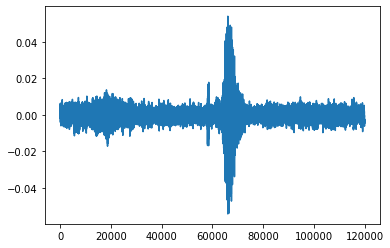

In [6]:
plt.plot(signal)
plt.show()

In [7]:
librosa_onsets(join('NorthEastUS_Bird_testset', wav_lst[0]))  # Using 'env' mode: over-sensitive

array([], dtype=float64)

In [132]:
librosa_onsets(join('ZD20K', 'outputs', wav_lst[0]), mode='time') # Default 'time', backtrack=True, After delta=0.2

array([0.32 , 0.576])

In [133]:
lib_count_lst = []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = librosa_onsets(join('ZD20K', 'outputs', file), mode='time')
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    if len(lib_count_lst) > 9:
        break
    
print(lib_count_lst)

[(2, [0.32, 0.576]), (1, [2.24]), (1, [0.8533333333333334]), (4, [0.256, 0.49066666666666664, 2.026666666666667, 2.8586666666666667]), (3, [0.042666666666666665, 2.0906666666666665, 2.517333333333333]), (1, [0.042666666666666665]), (1, [1.6853333333333333]), (4, [0.042666666666666665, 0.768, 0.8746666666666667, 0.9813333333333333]), (1, [0.6826666666666666]), (2, [0.042666666666666665, 3.925333333333333])]


In [63]:
assert len(lib_count_lst)==len(gt_lst)
lib_error_count = []
lib_error_onset_t = []
for idx, tup in enumerate(lib_count_lst):
    lib_error_count.append(abs(tup[0] - gt_lst[idx][0]))
    
# compute MSE of using Librosa for Crowd Counting
print(sum(lib_error_count) / len(lib_error_count))

12.2


### NorthEastUS Bird testset

In [19]:
lib_count_lst = []
anns = {}

for file in os.listdir(join('NorthEastUS_Bird_testset')):
  if file.endswith(".wav"):
    onset_time = librosa_onsets(join('NorthEastUS_Bird_testset', file), mode='time')
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    #if len(lib_count_lst) > 9:
    #    break
    
    item = {
             'fs': sr,
             'clip_length': 5.0,
             'lib_start_ts': onset_time.tolist(),
             'count_num_lib': len(onset_time),
            }
    anns[file] = item
    
print(len(anns))

800


In [20]:
ne_dir = 'NorthEastUS_Bird_testset'

with open(join('NorthEast_annotations_lib-aub-only.json'), 'w', encoding='utf-8') as f:
    json.dump(anns, f, ensure_ascii=False, indent=4)
print("Simulation Completed!")

Simulation Completed!


## Aubio

In [3]:
### Function of Using AUBIO for onset detection/counting ###
# file_path: absolute path to the sound clip
# win_div: hopping division by window size; default=4; use=2 for Counting
def get_onset_times(file_path, win_div=4):
    window_size = 1024 # FFT size
    hop_size = window_size // win_div

    sample_rate = 0
    src_func = source(file_path, sample_rate, hop_size)
    sample_rate = src_func.samplerate
    onset_func = onset('default', window_size, hop_size)
    
    duration = float(src_func.duration) / src_func.samplerate

    onset_times = [] # seconds
    while True: # read frames
        samples, num_frames_read = src_func()
        if onset_func(samples):
            onset_time = onset_func.get_last_s()
            if onset_time < duration:
                onset_times.append(onset_time)
            else:
                break
        if num_frames_read < hop_size:
            break
    
    return onset_times

In [136]:
file_path = join('ZD20K', 'outputs', wav_lst[0])
onset_times = get_onset_times(file_path)

In [143]:
count_lst = []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = get_onset_times(join('ZD20K', 'outputs', file), win_div=2)
    count_lst.append((len(onset_time), onset_time))
    if len(count_lst) > 9:
        break
    
print(count_lst)

[(7, [0.0, 0.2043083906173706, 0.3319047689437866, 1.1173468828201294, 1.9653061628341675, 2.059659957885742, 2.164625883102417]), (2, [1.2290703058242798, 1.7537188529968262]), (9, [0.48217687010765076, 0.6090475916862488, 1.3082993030548096, 1.517346978187561, 1.5733786821365356, 1.6295918226242065, 1.6893877983093262, 1.7456235885620117, 1.8044670820236206]), (10, [0.1531972736120224, 0.2757823169231415, 0.3731292486190796, 0.4663265347480774, 0.575986385345459, 0.7185714244842529, 0.7724036574363708, 0.8351020216941833, 1.6122221946716309, 1.7330158948898315]), (2, [0.0, 0.7468934059143066]), (1, [0.0]), (3, [0.9247392416000366, 1.2026077508926392, 1.2604762315750122]), (7, [0.15768706798553467, 0.2146485298871994, 0.26573696732521057, 0.3880952298641205, 1.1408843994140625, 1.2304534912109375, 1.338344693183899]), (6, [0.0, 0.41814059019088745, 0.9612471461296082, 1.346258521080017, 1.4593197107315063, 1.5599772930145264]), (1, [0.0])]


### NorthEast Bird testset

In [24]:
aub_count_lst = []
aub_anns = {}

assert os.path.exists(join('NorthEast_annotations_lib-aub-only.json'))

for file in os.listdir(join('NorthEastUS_Bird_testset')):
  if file.endswith('.wav'):
    onset_time = get_onset_times(join('NorthEastUS_Bird_testset', file), win_div=2)
    aub_count_lst.append((len(onset_time), onset_time))
    #if len(lib_count_lst) > 9:
    #    break
    
    anns[file]['aub_start_ts'] = onset_time
    item_name = 'count_num_aub'
    anns[file][item_name] = len(onset_time)
    
print(len(anns))

800


In [27]:
# Overwrite
with open(join('NorthEast_annotations_lib-aub-only.json'), 'w', encoding='utf-8') as f:
    json.dump(anns, f, ensure_ascii=False, indent=4)

### Ground-truth

In [ ]:
with open('annotations.json') as f:
    anns = json.load(f)

In [21]:
gt_lst = []

for file in os.listdir('outputs'):
    key_name = file.split('.')[0]
    
    start_ts = [item['start_t'] for item in anns[key_name]['birds']]
    
    gt_lst.append((anns[key_name]['count'], sorted(start_ts)))
    
print(gt_lst)

[(10, [0.015876305004615496, 0.04055874747533283, 0.8560014930756557, 1.113190095751739, 1.4673785172424894, 1.8090983152621483, 1.9343189066546818, 2.1345905017997007, 4.339293069060367, 5.427446743592197]), (10, [0.37726755844016974, 0.39026541015092964, 0.865730286394628, 1.289283348606935, 1.3144453738689539, 2.045300700875337, 4.526546265432463, 4.606212095954632, 4.9642929183415685, 5.358079898350199]), (10, [2.0422582831429015, 2.4019279826428646, 3.684572612475001, 4.631383724230315, 5.174263512148089, 5.808403381671271, 7.213222444554427, 7.247640891734407, 8.61479029189398, 9.305477105584105]), (10, [0.08957469750368154, 0.7055040435527499, 0.7437540168754013, 1.1322561652724625, 1.1368965504921866, 2.508784130854608, 2.9445331997541864, 3.1993645288836, 3.36240098300053, 4.24348693561246]), (10, [0.7902820896082009, 0.8351156931336404, 0.9657154572200708, 2.8727539475059127, 4.742736772641742, 4.8263467105994025, 6.537025166068086, 7.504311641580494, 7.643364108606821, 7.805

In [22]:
assert len(count_lst)==len(gt_lst)
error_count = []
error_onset_t = []
for idx, tup in enumerate(count_lst):
    error_count.append(abs(tup[0] - gt_lst[idx][0]))
    
# compute MSE of using Aubio for Crowd Counting
print(sum(error_count) / len(error_count))

3.6


# TUT-SED Synthetic 2016

In [19]:
# path to annotation directory (meta dir)
path_to_meta = "/home/zdai/repos/TUT-SED_Synthetic_2016/TUT-SED-synthetic-2016.meta/TUT-SED-synthetic-2016/meta"

TUT = {}
max_event_t = 0.0

# Load TUT2016 dataset annotations into TUT: a dictionary of sound event classes, start_t, end_t
for filename in os.listdir(path_to_meta):
    with open(join(path_to_meta, filename), 'r') as f:
        lines = f.readlines()
    #print(lines)
    
    sound_srcs = []
    for item in lines:
        t1 = float(item.split('\t')[0])
        t2 = float(item.split('\t')[1])
        if t2 > max_event_t:
            max_event_t = t2
        cls = item.split('\t')[2][:-1]
        
        sound_srcs.append({"cls": cls,
                          "start_t": t1,
                          "end_t": t2})
    tut = {"clip_t": max_event_t,
          "events": sound_srcs}
    TUT[filename] = tut

print("Number of original TUT-SED Synthetic 2016 samples = ", len(TUT))

100


In [ ]:
### Compute the Polyphonic Level/Ratio/Density of original TUT clip ###
def polyphony(clip):
    step = 0.01

    t = np.arange(0, clip['clip_t'], step)
    t_tp = np.zeros(t.shape)
    t_den = np.zeros(t.shape)
    t_area = np.zeros(t.shape)

    max_track = 0

    for idx, x in np.ndenumerate(t):
        mono_track = 0
        for instance in clip['events']:
            if x >= instance['start_t'] and x <= instance['end_t']:
                mono_track += 1

        if mono_track >= 2:
            t_tp[idx] = step
            t_den[idx] = math.e**mono_track * step
            t_area[idx] = mono_track * step

        max_track = mono_track if mono_track > max_track else max_track

    polyphonic_ratio = np.sum(t_tp) / clip['clip_t']
    polyphonic_density = np.sum(t_den) / clip['clip_t']
    # Specify Max number of "wall": donno know height of wall here
    #polyphonic_area = np.sum(t_area) / (clip['clip_t'] * 5)

    PL = max_track
    PR = polyphonic_ratio
    PD = polyphonic_density
    return PL, PR, PD

In [151]:
TUT_stats = []
max_PL = 0

for idx, (key, val) in enumerate(TUT.items()):
    pl, pr, pd = polyphony(val)
    TUT_stats.append((pl, pr, pd))
    if pl > max_PL:
        max_PL = pl
    #break
    
print("Max Polyphony Level Ever in TUT-SED Synthetic 2016 = ", max_PL)

Max Polyphony Level Ever in TUT-SED Synthetic 2016 =  6


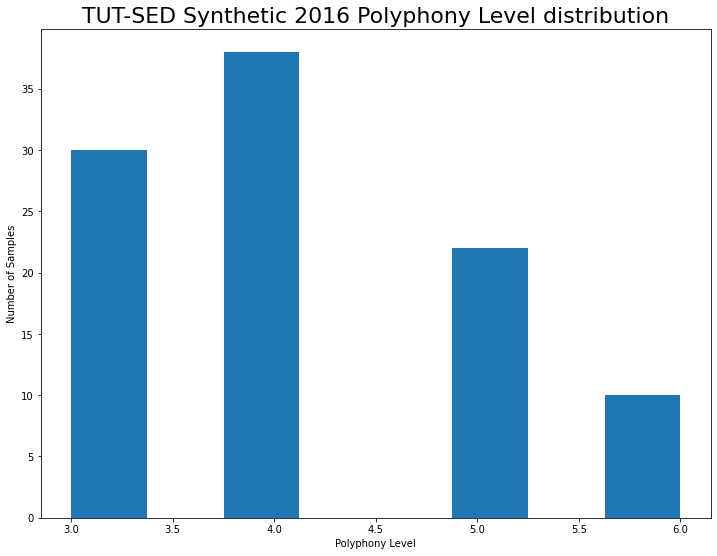

In [152]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist([int(item[0]) for item in TUT_stats], bins='auto', rwidth=0.99)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")
ax3.set_title("TUT-SED Synthetic 2016 Polyphony Level distribution", fontsize=22)

fig3.savefig('TUT2016_hist.png')
plt.show()

## Dataset Transformation
### Chop Recordings into 5s clips

In [133]:
# Specify path to audio files dirs
path_to_dir = "/home/zdai/repos/TUT-SED_Synthetic_2016"
dir1 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.1', 'TUT-SED-synthetic-2016', 'audio')
dir2 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.2', 'TUT-SED-synthetic-2016', 'audio')
dir3 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.3', 'TUT-SED-synthetic-2016', 'audio')
dir4 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.4', 'TUT-SED-synthetic-2016', 'audio')
dir5 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.5', 'TUT-SED-synthetic-2016', 'audio')

# Sampling rate
sr = 24000

# Uniform clip length (s)
clip_t = 5

In [ ]:
### Create single annotation for each (5)s clip ###
# tut: dictionary of original annotation [make sure to extract Ground-truth annotation
#      including 'class', 'start_t', 'end_t' from original dataset, e.g., <TUT> in last section]
# start_t: Start timestamp in the original clip
# end_t: Ending timestamp in the original clip
# sr: sampling rate
def create_wav_ann(tut, start_t, end_t, sr):
    # Atomic temporal step of integral to compute PL, PR, PD etc.
    # The small the better resolution, but costs more tiem to compute
    step = 0.01

    t = np.arange(start_t, end_t, step)
    t_tp = np.zeros(t.shape)
    t_den = np.zeros(t.shape)
    t_area = np.zeros(t.shape)
    
    max_track = 0
    sound_srcs = []
    
    # Determine sound instances that occur in the sub-clip
    for instance in tut['events']:
        if start_t < instance['end_t'] and end_t > instance['start_t']:
            t1 = instance['start_t'] if instance['start_t']>start_t else start_t
            t2 = instance['end_t'] if instance['end_t']<end_t else end_t
            
            end_time = t2 % (end_t - start_t) if t2 % (end_t - start_t) != 0 else end_t - start_t
            
            sound_srcs.append({"BirdName": instance['cls'],
                                      "start_t": t1 % (end_t - start_t),
                                      "end_t": end_time})
    
    # Compute PL, PR, PA, PD
    for idx, x in np.ndenumerate(t):
        mono_track = 0
        for instance in tut['events']:
            if x > instance['start_t'] and x < instance['end_t']:
                mono_track += 1
                
        if mono_track >= 2:
            t_tp[idx] = step
            t_den[idx] = math.e**mono_track * step
            t_area[idx] = mono_track * step

        max_track = mono_track if mono_track > max_track else max_track

    polyphonic_ratio = np.sum(t_tp) / (end_t - start_t)
    polyphonic_density = np.sum(t_den) / (end_t - start_t)
    # Specify Max number of "wall": donno know height of wall here
    polyphonic_area = np.sum(t_area) / (end_t - start_t)

    PL = max_track
    PR = polyphonic_ratio
    PD = polyphonic_density
    PA = polyphonic_area
    
    # Annotation for the Sub-clip
    item = {
             'fs': sr,
             'clip_length': end_t - start_t,
             'birds': sound_srcs,
             'count': len(sound_srcs),
             'PolyphonicRatio': PR,
             'PolyphonicDensity': PD,
             'PolyphonyLevel': PL,
             'PolyphonicArea': PA,
            }
    
    return item

In [150]:
# Outputs dir
tut_dir = 'TUT2016'
os.makedirs(join(tut_dir, 'outputs')) if not os.path.exists(join(tut_dir, 'outputs')) else None

# Dictionary of all Annotations
annotations = {}

for dir0 in [dir1, dir2, dir3, dir4, dir5]:
    for file in os.listdir(dir0):
        signal, fs = librosa.load(join(dir0, file), sr=sr)

        fileidx = file.split('.')[0].split('-')[-1]
        wavname = 'TUT-SED-synthetic-2016-mix-' + fileidx
        annname = 'TUT-SED-synthetic-2016-annot-' + fileidx

        num_clips = len(signal) // (clip_t * sr)

        for index in range(num_clips):

            filename = "mix-{}_index-{}".format(int(fileidx), index)

            # Create .wav
            soundfile.write(file=join(tut_dir, 'outputs', filename+'.wav'), 
                            data=signal[index * clip_t * sr:(index+1) * clip_t * sr], 
                            samplerate=sr)

            # Add annotation
            ann = create_wav_ann(TUT[annname+'.txt'], index * clip_t, (index+1) * clip_t, sr)

            annotations[filename] = ann

            #if index >=10:
            #    break
        #break

            
if os.path.exists(join(tut_dir, 'TUTannotations.json')):
    with open(join(tut_dir, 'TUTannotations.json')) as f:
        new_anns = json.load(f)

    new_anns.update(annotations)
    with open(join(tut_dir, 'TUTannotations.json'), 'w', encoding='utf-8') as f:
        json.dump(new_anns, f, ensure_ascii=False, indent=4)
else:
    with open(join(tut_dir, 'TUTannotations.json'), 'w', encoding='utf-8') as f:
        json.dump(annotations, f, ensure_ascii=False, indent=4)
print("Simulation Completed!")

Simulation Completed!


# Evaluation

In [ ]:
# Load annotations
with open(join('annotations_pred.json')) as f:
    anns = json.load(f)

with open(join('annotations_pred_6_10.json')) as f:
    anns6_10 = json.load(f)
    
anns.update(anns6_10)
print(len(anns))

In [40]:
# Load Rooster-only annotation
with open(join('annotations_pred_6_10_rooster.json')) as f:
    anns = json.load(f)
print(len(anns))

80000


In [44]:
# Load count 1-10 fully
with open(join('annotations_pred_1_10_epoch40_v2.json')) as f:
    anns = json.load(f)
print(len(anns))

7998


## Librosa & Aubio eval

In [45]:
num_of_onset_samples = 0

# Use Librosa(lib) / Aubio(aub) to count test .wavs in "ZD20K_count1-10" dataset
for index, (filename, item) in enumerate(anns.items()):
    if item['count_num_pred'] is not None:
        if os.path.isfile(join('ZD20K', 'outputs', filename + '.wav')):
            path_to_file = join('ZD20K', 'outputs', filename + '.wav')
        elif os.path.isfile(join('ZD20K_count6-10', 'outputs', filename + '.wav')):
            path_to_file = join('ZD20K_count6-10', 'outputs', filename + '.wav')
        else:
            raise ValueError(filename + '.wav', " does not exist!")
            
        onset_time = librosa_onsets(path_to_file, mode='time')
        librosa_count = len(onset_time)
        anns[filename]['count_num_lib'] = librosa_count
        
        onset_times_aub = get_onset_times(path_to_file, win_div=2)
        aub_count = len(onset_times_aub)
        anns[filename]['count_num_aub'] = aub_count
        
        num_of_onset_samples += 1
        
print("Detected total samples = ", num_of_onset_samples)

Detected total samples =  7998


In [46]:
# Save updated anns with grount-truth lib & aub
with open('annotations_pred_1_10_epoch40_v2_4birds-lib-aub.json', 'w', encoding='utf-8') as f:
    json.dump(anns, f, ensure_ascii=False, indent=4)

## Hyperparam: Count's correlation to P.L. P.R. P.A. P.D.

### (Yuhang: skip this part)

In [3]:
sort_attr = 'PolyphonyLevel'
PR_lst = sorted(anns.items(), key=lambda x: x[1][sort_attr], reverse=True)

In [4]:
len(PR_lst)

40000

In [5]:
count_lst, pl_lst, pa_lst, pr_lst, pd_lst = [], [], [], [], []

for item in PR_lst:
    pl_lst.append(item[1]['PolyphonyLevel'])
    pa_lst.append(item[1]['PolyphonicArea'])
    pr_lst.append(item[1]['PolyphonicRatio'])
    pd_lst.append(item[1]['PolyphonicDensity'])
    count_lst.append(item[1]['count'])

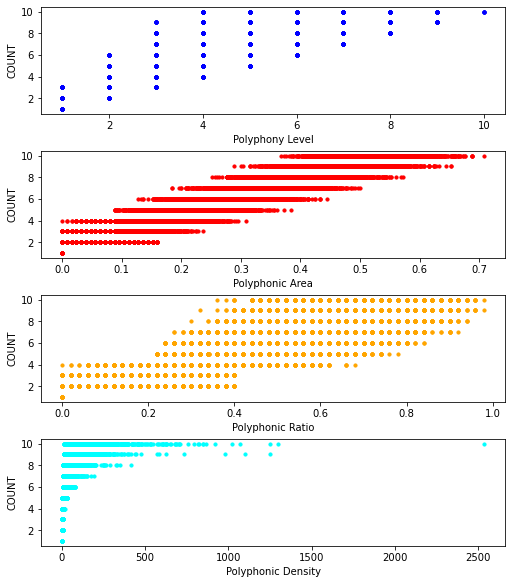

In [6]:
fig, ax = plt.subplots(4, 1, figsize=(7, 8), constrained_layout=True)

ax[0].scatter(pl_lst, count_lst, color='b', s=10)
ax[0].set_xlabel("Polyphony Level")
ax[0].set_ylabel("COUNT")

ax[1].scatter(pa_lst, count_lst, color='r', s=10)
ax[1].set_xlabel("Polyphonic Area")
ax[1].set_ylabel("COUNT")

ax[2].scatter(pr_lst, count_lst, color='orange', s=10)
ax[2].set_xlabel("Polyphonic Ratio")
ax[2].set_ylabel("COUNT")

ax[3].scatter(pd_lst, count_lst, color='cyan', s=10)
ax[3].set_xlabel("Polyphonic Density")
ax[3].set_ylabel("COUNT")

#fig.savefig('ZD20K_distribution', facecolor='white', transparent=False)
plt.show()

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


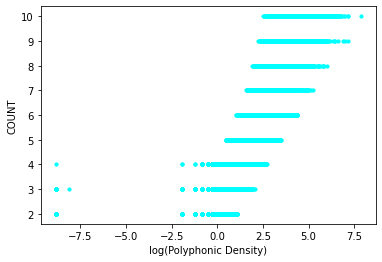

In [7]:
fig2, ax2 = plt.subplots()

ax2.scatter(np.log(pd_lst), count_lst, color='cyan', s=10)
ax2.set_xlabel("log(Polyphonic Density)")
ax2.set_ylabel("COUNT")

#fig2.savefig('ZD20K_log-polyphonicDensity', facecolor='white', transparent=False)
plt.show()

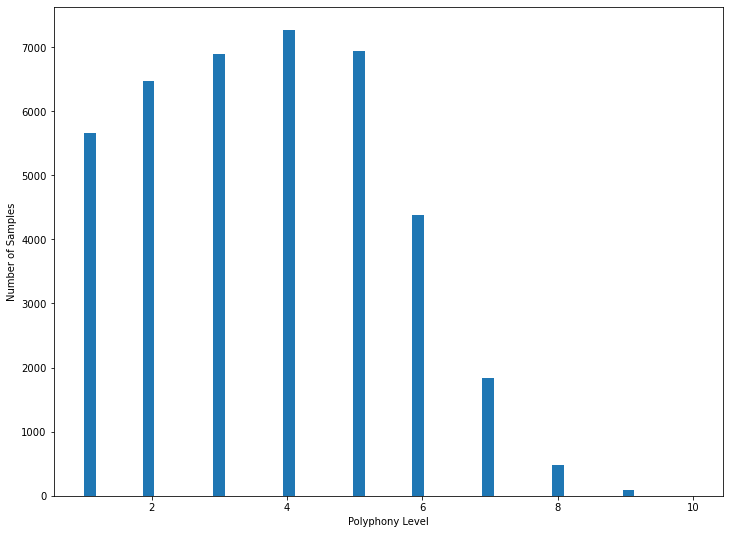

In [11]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(pl_lst, bins='auto', rwidth=0.99)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

## Polyphony Level

In [138]:
# Load Four-bird annotations
with open(join('annotations_pred.json')) as f:
    anns = json.load(f)

with open(join('annotations_pred_6_10.json')) as f:
    anns6_10 = json.load(f)

anns.update(anns6_10)
print(len(anns))

40000


In [111]:
# Load Rooster-only annotation
with open(join('annotations_pred_6_10_rooster.json')) as f:
    anns = json.load(f)
    
with open(join('annotations_pred_1_5_rooster.json')) as f:
    anns1_5 = json.load(f)

anns1_5_firsthalf = dict(itertools.islice(anns1_5.items(), 20000))

anns.update(anns1_5_firsthalf)
print(len(anns))

80000


In [7]:
# Load Complete annotations
with open(join('annotations_pred_1_10_epoch60_4birds-lib-aub.json')) as f:
    anns = json.load(f)
print(len(anns))

7998


In [7]:
# Number of min samples in a bin to be consider for histogram analysis
hist_thres = 10

In [8]:
### Sort annotations in order of an attribute ###
# ann: annotations dictionary
# sort_attr: Sort by order of an attribute
def eval_polyphony(ann, sort_attr = 'PolyphonyLevel'):
    
    PR_lst = sorted(ann.items(), key=lambda x: x[1][sort_attr], reverse=False)
    
    attr_lst = []
    count_num_pred_lst, count_lst = [], []
    snr_lst = []
    lib_lst, aub_lst = [], []

    for item in PR_lst:
        if item[1]['count_num_pred'] is not None:
            attr_lst.append(item[1][sort_attr])
            count_lst.append(item[1]['count'])
            count_num_pred_lst.append(item[1]['count_num_pred'])
            snr_lst.append(item[1]['snr'])
            
            lib_lst.append(item[1]['count_num_lib'])
            aub_lst.append(item[1]['count_num_aub'])
            
            
    print("Number of test samples = ", len(attr_lst))
    
    return attr_lst, count_num_pred_lst, count_lst, snr_lst, lib_lst, aub_lst

In [47]:
X, Y_gt, Y_pred, SNR, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonyLevel')

Number of test samples =  7998


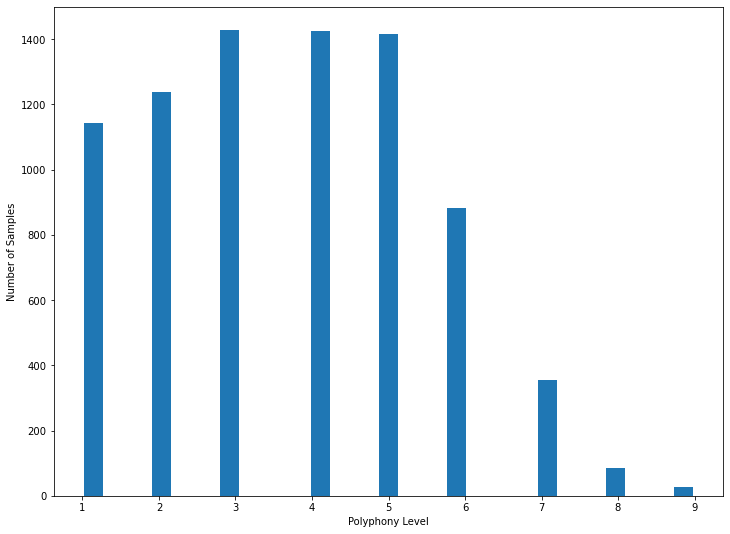

In [48]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")

#fig3.savefig(join('images', '4bird_count1-10_hist'))
plt.show()

In [11]:
### Compute MSE, MDE, Accuracy ###
# y_gt: ground truth list
# y_pred: prediction list
def get_metric(y_gt, y_pred):
    mse_sum = 0
    mde_sum = 0
    acc_sum = 0
    
    if len(y_pred) == 0:
        return None, None, None

    for idx, gt in enumerate(y_gt):
        mse_sum += abs(gt - y_pred[idx])**2
        mde_sum += abs(gt - y_pred[idx])
        if gt == y_pred[idx]:
            acc_sum += 1
    
    
    MSE = mse_sum / len(y_gt)
    MDE = mde_sum / len(y_gt)
    Accuracy = acc_sum / len(y_gt)

    print("MSE = %.3f; MDE = %.3f; Accuracy = %.2f%%" % (MSE, MDE, Accuracy*100))
    
    return MSE, MDE, Accuracy

In [49]:
PL_metric = {}
max_PL = 10

# Compute Metrics bin by bin, e.g., PL = 1 to 10 here
for i in range(1, max_PL + 1, 1):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val == i:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)
    
        PL_metric[i] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PL_metric)
PL_metric_acc = [item[2][0] for item in list(PL_metric.values())]
PL_metric_MSE = [item[0][0] for item in list(PL_metric.values())]
PL_metric_MDE = [item[1][0] for item in list(PL_metric.values())]
PL_metric_acc_lib = [item[2][1] for item in list(PL_metric.values())]
PL_metric_MSE_lib = [item[0][1] for item in list(PL_metric.values())]
PL_metric_MDE_lib = [item[1][1] for item in list(PL_metric.values())]
PL_metric_acc_aub = [item[2][2] for item in list(PL_metric.values())]
PL_metric_MSE_aub = [item[0][2] for item in list(PL_metric.values())]
PL_metric_MDE_aub = [item[1][2] for item in list(PL_metric.values())]

MSE = 5.747; MDE = 1.994; Accuracy = 5.07%
MSE = 7.971; MDE = 2.118; Accuracy = 16.87%
MSE = 4.913; MDE = 1.735; Accuracy = 16.70%
MSE = 4.525; MDE = 1.707; Accuracy = 12.05%
MSE = 11.845; MDE = 2.844; Accuracy = 7.92%
MSE = 7.461; MDE = 2.158; Accuracy = 15.84%
MSE = 2.612; MDE = 1.213; Accuracy = 25.14%
MSE = 16.471; MDE = 3.608; Accuracy = 4.13%
MSE = 9.459; MDE = 2.399; Accuracy = 13.59%
MSE = 1.487; MDE = 0.825; Accuracy = 43.26%
MSE = 23.940; MDE = 4.490; Accuracy = 1.97%
MSE = 10.352; MDE = 2.553; Accuracy = 12.15%
MSE = 1.952; MDE = 0.866; Accuracy = 50.99%
MSE = 31.047; MDE = 5.136; Accuracy = 1.77%
MSE = 12.356; MDE = 2.814; Accuracy = 10.52%
MSE = 3.152; MDE = 1.111; Accuracy = 51.87%
MSE = 36.215; MDE = 5.558; Accuracy = 1.82%
MSE = 12.594; MDE = 2.816; Accuracy = 11.12%
MSE = 3.461; MDE = 1.202; Accuracy = 50.00%
MSE = 37.624; MDE = 5.669; Accuracy = 1.97%
MSE = 11.764; MDE = 2.713; Accuracy = 12.64%
MSE = 5.663; MDE = 1.616; Accuracy = 47.67%
MSE = 37.058; MDE = 5.616; Ac

#### (Run below section only if you want to analyze based on high/low SNR instead)

In [115]:
snr_thred = -26.5  # -26.5 to differ clean/noisy; -9999 to not separate

In [83]:
# Eval performance based on SNR
PL_metric = {}
max_PL = 10

for i in range(1, max_PL + 1, 1):
    gt, pred = [], []
    gt_noisy, pred_noisy = [], []
    for idx, val in enumerate(X):
        if val == i:
            if SNR[idx] > snr_thred:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx])
            else:
                gt_noisy.append(Y_gt[idx])
                pred_noisy.append(Y_pred[idx])
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
    elif len(gt)==0:
        mse, mde, accu = None, None, None
    if len(gt_noisy) >= hist_thres:
        mse_noisy, mde_noisy, accu_noisy = get_metric(gt_noisy, pred_noisy)
    elif len(gt_noisy)==0:
        mse_noisy, mde_noisy, accu_noisy = None, None, None
    PL_metric[i] = ([mse, mse_noisy], [mde, mde_noisy], [accu, accu_noisy])
    
print(PL_metric)
PL_metric_acc = [item[2][0] for item in list(PL_metric.values())]
PL_metric_MSE = [item[0][0] for item in list(PL_metric.values())]
PL_metric_MDE = [item[1][0] for item in list(PL_metric.values())]
PL_metric_acc_noisy = [item[2][1] for item in list(PL_metric.values())]
PL_metric_MSE_noisy = [item[0][1] for item in list(PL_metric.values())]
PL_metric_MDE_noisy = [item[1][1] for item in list(PL_metric.values())]

MSE = 0.010; MDE = 0.010; Accuracy = 98.96%
MSE = 0.099; MDE = 0.089; Accuracy = 91.38%
MSE = 1.349; MDE = 0.600; Accuracy = 64.76%
MSE = 2.426; MDE = 1.125; Accuracy = 35.05%
MSE = 2.286; MDE = 1.173; Accuracy = 26.32%
MSE = 2.317; MDE = 1.198; Accuracy = 24.43%
MSE = 2.630; MDE = 1.288; Accuracy = 22.86%
MSE = 3.061; MDE = 1.485; Accuracy = 11.36%
MSE = 4.885; MDE = 1.962; Accuracy = 11.54%
{1: ([0.01043115438108484, None], [0.01043115438108484, None], [0.9895688456189151, None]), 2: ([0.09913793103448276, None], [0.08928571428571429, None], [0.9137931034482759, None]), 3: ([1.3494335122242098, None], [0.6004770423375074, None], [0.6475849731663685, None]), 4: ([2.426495248742314, None], [1.1252096143096701, None], [0.3504751257685858, None]), 5: ([2.2857142857142856, None], [1.172811059907834, None], [0.2632488479262673, None]), 6: ([2.316742081447964, None], [1.1981900452488687, None], [0.24434389140271492, None]), 7: ([2.6303418803418803, None], [1.2884615384615385, None], [0.2286

#### (end)

### Plots
#### 1. Rooster-only

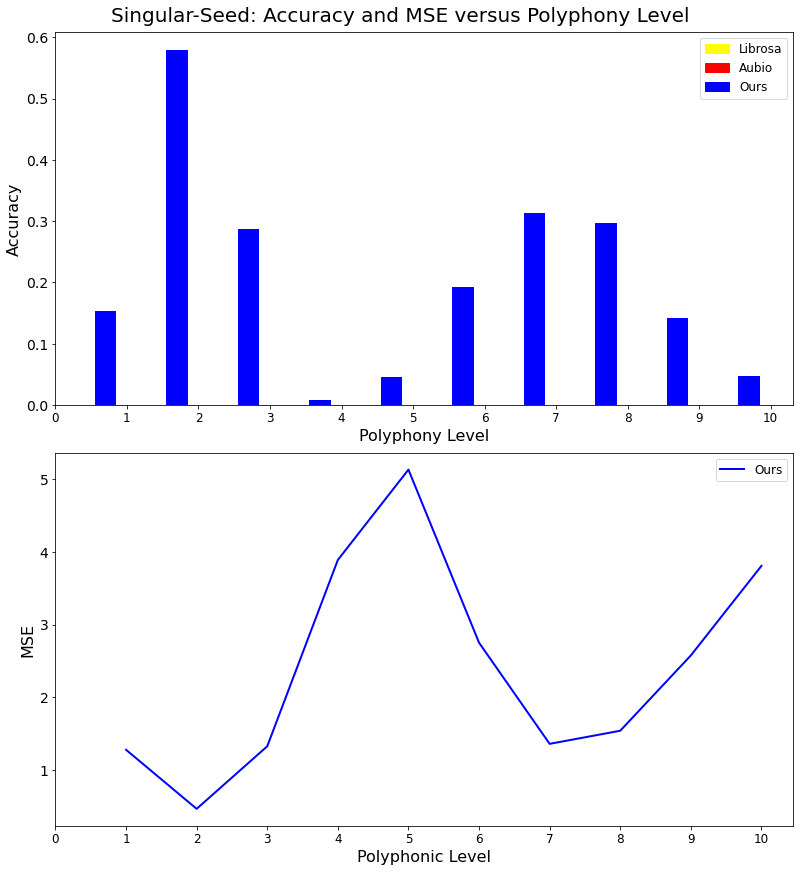

In [116]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
width = 0.3
x_lst = list(PL_metric)

x1 = [x - width*1.0 for x in x_lst]
ax[0].bar(x1, PL_metric_acc, color='b', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
'''
ax[0].bar(x_lst, PL_metric_acc_lib, color='y', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x2 = [x + width*1.0 for x in x_lst]
ax[0].bar(x2, PL_metric_acc_aub, color='r', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
'''
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

'''
ax[1].plot(list(PL_metric), PL_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PL_metric), PL_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[1].plot(list(PL_metric), PL_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Singular-Seed: Accuracy and MSE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(max(x_lst) + 1), xticklabels=range(max(x_lst) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(max(x_lst) + 1), range(max(x_lst) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(max(x_lst) + 1), range(max(x_lst) + 1), color='k', fontsize=12)

# Legends
colors = {'Librosa':'yellow', 'Aubio':'red', 'Ours':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax[0].legend(handles, labels, prop={'size': 12})

ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'RO1-10_PL'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-birds v.s. other methods

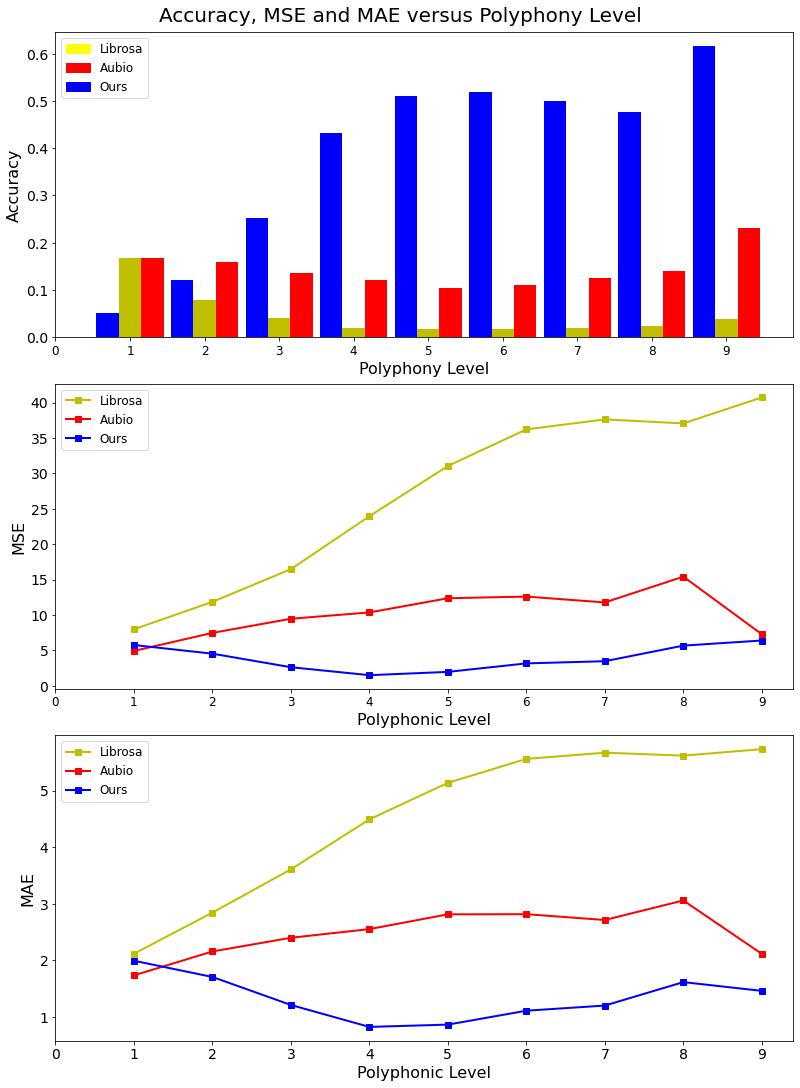

In [50]:
fig, ax = plt.subplots(3, 1, figsize=(11, 15), constrained_layout=True)
width = 0.3
x_lst = list(PL_metric)

x1 = [x - width*1.0 for x in x_lst]
ax[0].bar(x1, PL_metric_acc, color='b', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].bar(x_lst, PL_metric_acc_lib, color='y', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x2 = [x + width*1.0 for x in x_lst]
ax[0].bar(x2, PL_metric_acc_aub, color='r', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PL_metric), PL_metric_MSE_lib, color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PL_metric), PL_metric_MSE_aub, color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PL_metric), PL_metric_MSE, color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

ax[2].plot(list(PL_metric), PL_metric_MDE_lib, color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[2].plot(list(PL_metric), PL_metric_MDE_aub, color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[2].plot(list(PL_metric), PL_metric_MDE, color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MAE", fontsize=16)
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=14) 
ax[2].tick_params(axis="y", labelsize=14) 

fig.suptitle("Accuracy, MSE and MAE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(len(PL_metric) + 1), xticklabels=range(len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)

# Legends
colors = {'Librosa':'yellow', 'Aubio':'red', 'Ours':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax[0].legend(handles, labels, prop={'size': 12})

ax[1].legend(loc='best', prop={'size': 12})
ax[2].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'ours_4bird', '40K_PL_epoch40_v2'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 3. Attribute: SNR level (only if you have ran the SNR section)

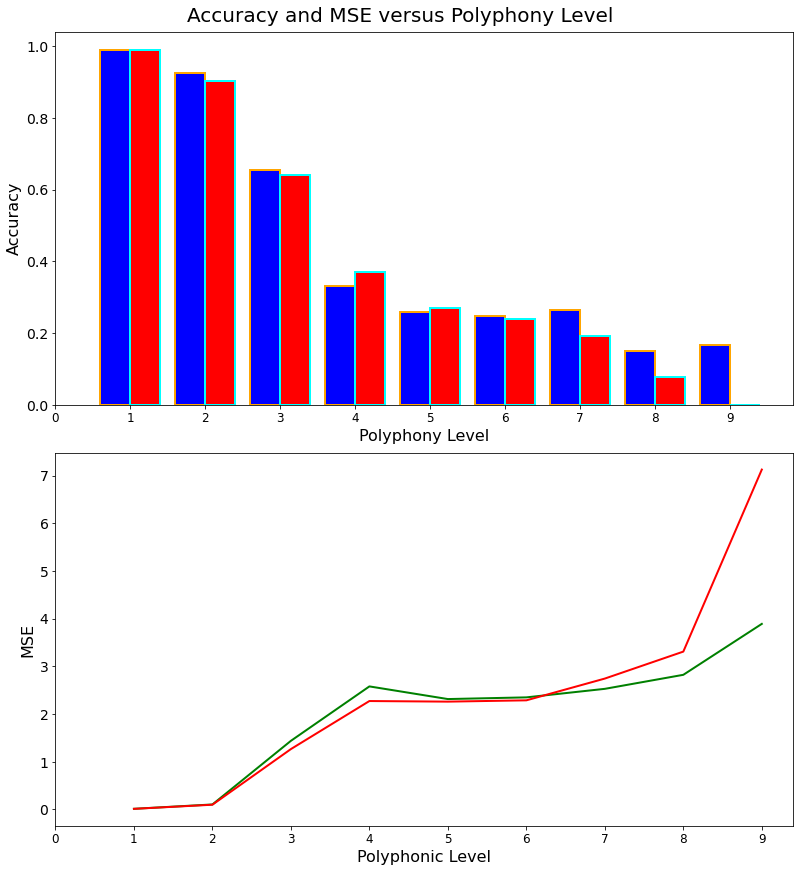

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
width = 0.4

x_lst = list(PL_metric)
x_lst = [x-width/2 for x in x_lst]
ax[0].bar(x_lst, PL_metric_acc, color='b', 
       edgecolor='orange', linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x_lst2 = list(PL_metric)
x_lst2 = [x+width/2 for x in x_lst2]
ax[0].bar(x_lst2, PL_metric_acc_noisy, color='r', 
       edgecolor='cyan', linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PL_metric), PL_metric_MSE, color='g', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].plot(list(PL_metric), PL_metric_MSE_noisy, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(len(PL_metric) + 1), xticklabels=range(len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)

fig.savefig(join('images', '40K_PL_SNR'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Ratio

In [51]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicRatio')

Number of test samples =  7998


In [52]:
PR_metric = {}
bins = 10  # Number of bins for Histogram analysis

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > i/bins and val <= i/bins + 1/bins:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PR_metric[i/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PR_metric)
PR_metric_acc = [item[2][0] for item in list(PR_metric.values())]
PR_metric_MSE = [item[0][0] for item in list(PR_metric.values())]
PR_metric_MDE = [item[1][0] for item in list(PR_metric.values())]
PR_metric_acc_lib = [item[2][1] for item in list(PR_metric.values())]
PR_metric_MSE_lib = [item[0][1] for item in list(PR_metric.values())]
PR_metric_MDE_lib = [item[1][1] for item in list(PR_metric.values())]
PR_metric_acc_aub = [item[2][2] for item in list(PR_metric.values())]
PR_metric_MSE_aub = [item[0][2] for item in list(PR_metric.values())]
PR_metric_MDE_aub = [item[1][2] for item in list(PR_metric.values())]

MSE = 5.775; MDE = 1.953; Accuracy = 7.51%
MSE = 13.216; MDE = 2.869; Accuracy = 9.39%
MSE = 8.178; MDE = 2.207; Accuracy = 18.31%
MSE = 4.296; MDE = 1.694; Accuracy = 9.61%
MSE = 11.192; MDE = 2.766; Accuracy = 7.53%
MSE = 6.969; MDE = 2.086; Accuracy = 15.06%
MSE = 3.880; MDE = 1.563; Accuracy = 13.88%
MSE = 13.650; MDE = 3.150; Accuracy = 6.19%
MSE = 7.883; MDE = 2.193; Accuracy = 14.91%
MSE = 2.762; MDE = 1.266; Accuracy = 23.04%
MSE = 14.816; MDE = 3.436; Accuracy = 4.76%
MSE = 9.221; MDE = 2.413; Accuracy = 13.21%
MSE = 1.993; MDE = 1.003; Accuracy = 35.40%
MSE = 19.163; MDE = 3.930; Accuracy = 3.68%
MSE = 9.758; MDE = 2.466; Accuracy = 12.49%
MSE = 2.109; MDE = 0.937; Accuracy = 45.63%
MSE = 26.273; MDE = 4.691; Accuracy = 2.12%
MSE = 10.109; MDE = 2.532; Accuracy = 12.79%
MSE = 2.157; MDE = 0.912; Accuracy = 50.77%
MSE = 32.069; MDE = 5.231; Accuracy = 1.63%
MSE = 12.076; MDE = 2.765; Accuracy = 11.82%
MSE = 2.492; MDE = 0.946; Accuracy = 55.11%
MSE = 36.317; MDE = 5.583; Accur

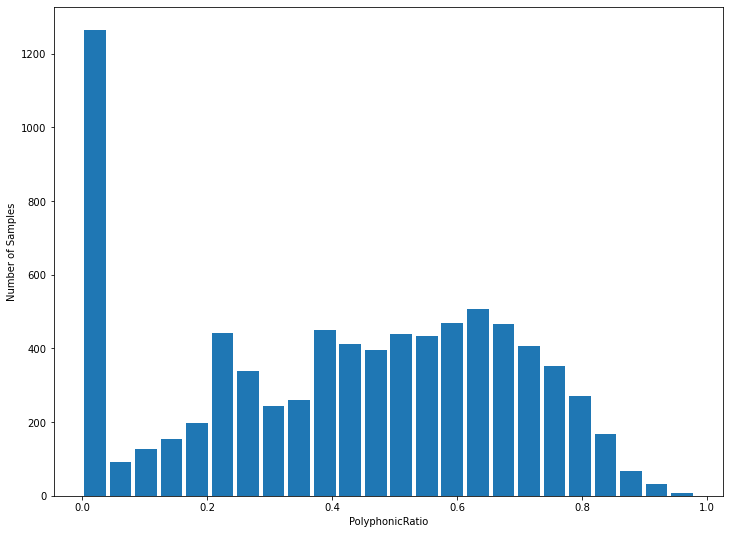

In [16]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicRatio")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

#### 1. Rooster-only

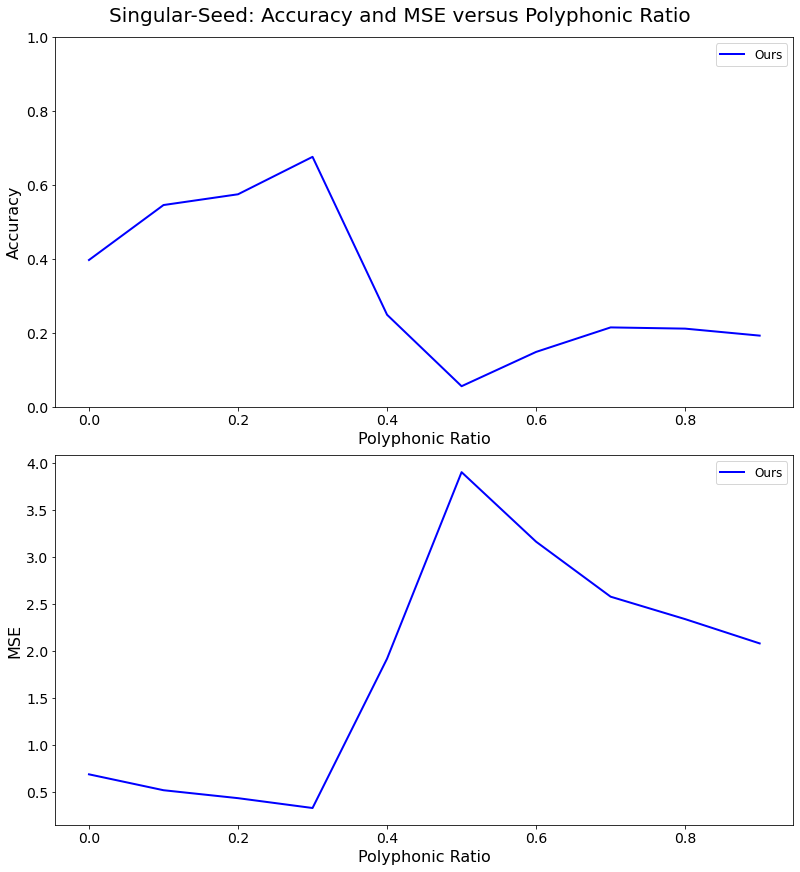

In [120]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
'''
ax[0].plot(list(PR_metric), PR_metric_acc_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PR_metric), PR_metric_acc_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[0].plot(list(PR_metric), PR_metric_acc, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

'''
ax[1].plot(list(PR_metric), PR_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PR_metric), PR_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[1].plot(list(PR_metric), PR_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Singular-Seed: Accuracy and MSE versus Polyphonic Ratio", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'RO1-10_PR'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

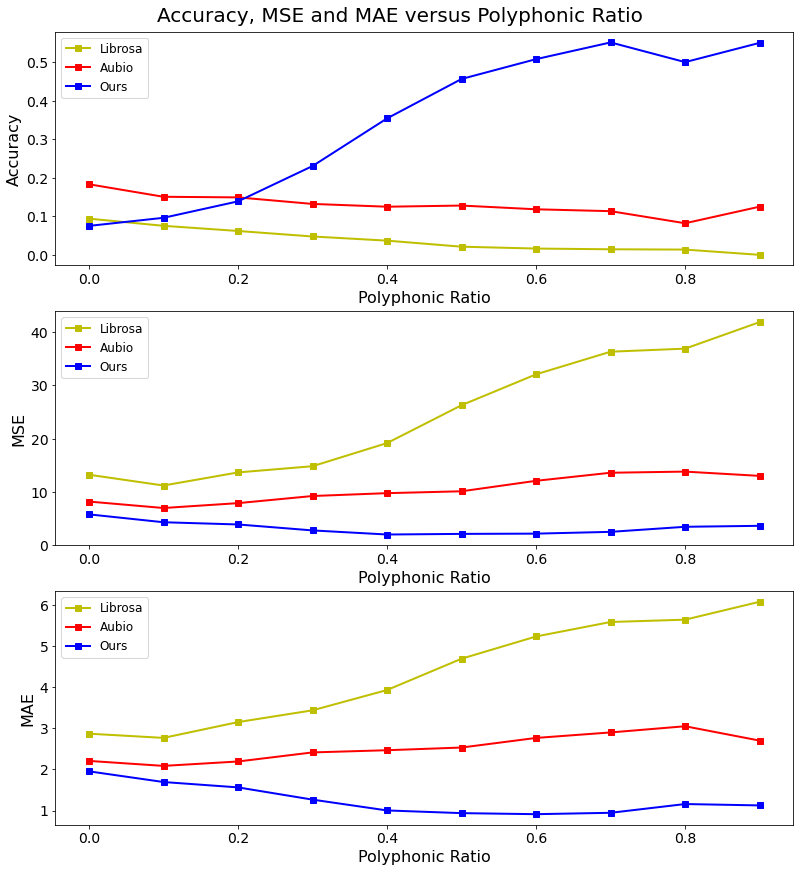

In [53]:
fig, ax = plt.subplots(3, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PR_metric), PR_metric_acc_lib, color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PR_metric), PR_metric_acc_aub, color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PR_metric), PR_metric_acc, color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PR_metric), PR_metric_MSE_lib, color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PR_metric), PR_metric_MSE_aub, color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PR_metric), PR_metric_MSE, color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

ax[2].plot(list(PR_metric), PR_metric_MDE_lib, color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[2].plot(list(PR_metric), PR_metric_MDE_aub, color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[2].plot(list(PR_metric), PR_metric_MDE, color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[2].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[2].set_ylabel("MAE", fontsize=16)
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=14) 
ax[2].tick_params(axis="y", labelsize=14) 

fig.suptitle("Accuracy, MSE and MAE versus Polyphonic Ratio", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})
ax[2].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'ours_4bird', '40K_PR_epoch40_v2'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Area

In [54]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicArea')

Number of test samples =  7998


In [55]:
PA_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > i/bins and val <= i/bins + 1/bins:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PA_metric[i/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])
    
print(PA_metric)
PA_metric_acc = [item[2][0] for item in list(PA_metric.values())]
PA_metric_MSE = [item[0][0] for item in list(PA_metric.values())]
PA_metric_MDE = [item[1][0] for item in list(PA_metric.values())]
PA_metric_acc_lib = [item[2][1] for item in list(PA_metric.values())]
PA_metric_MSE_lib = [item[0][1] for item in list(PA_metric.values())]
PA_metric_MDE_lib = [item[1][1] for item in list(PA_metric.values())]
PA_metric_acc_aub = [item[2][2] for item in list(PA_metric.values())]
PA_metric_MSE_aub = [item[0][2] for item in list(PA_metric.values())]
PA_metric_MDE_aub = [item[1][2] for item in list(PA_metric.values())]

MSE = 4.682; MDE = 1.756; Accuracy = 9.34%
MSE = 11.958; MDE = 2.826; Accuracy = 8.11%
MSE = 7.237; MDE = 2.116; Accuracy = 16.22%
MSE = 3.152; MDE = 1.371; Accuracy = 19.92%
MSE = 14.132; MDE = 3.311; Accuracy = 5.21%
MSE = 9.053; MDE = 2.357; Accuracy = 13.77%
MSE = 1.681; MDE = 0.940; Accuracy = 34.72%
MSE = 19.554; MDE = 4.026; Accuracy = 2.76%
MSE = 9.550; MDE = 2.438; Accuracy = 12.36%
MSE = 1.203; MDE = 0.684; Accuracy = 53.51%
MSE = 26.838; MDE = 4.780; Accuracy = 1.96%
MSE = 11.064; MDE = 2.648; Accuracy = 12.60%
MSE = 2.500; MDE = 0.971; Accuracy = 53.49%
MSE = 35.796; MDE = 5.587; Accuracy = 1.46%
MSE = 12.487; MDE = 2.820; Accuracy = 10.59%
MSE = 4.397; MDE = 1.371; Accuracy = 49.03%
MSE = 40.067; MDE = 5.832; Accuracy = 1.63%
MSE = 13.637; MDE = 2.945; Accuracy = 11.44%
MSE = 5.984; MDE = 1.672; Accuracy = 43.75%
MSE = 42.859; MDE = 6.047; Accuracy = 0.00%
MSE = 19.266; MDE = 3.516; Accuracy = 6.25%
{0.0: ([4.681724845995893, 11.957905544147843, 7.237166324435318], [1.7556

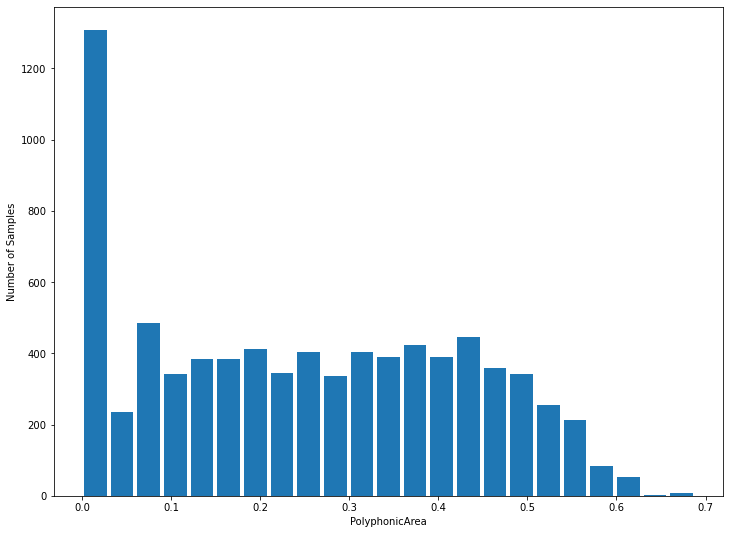

In [20]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicArea")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

#### 1. Rooster-only

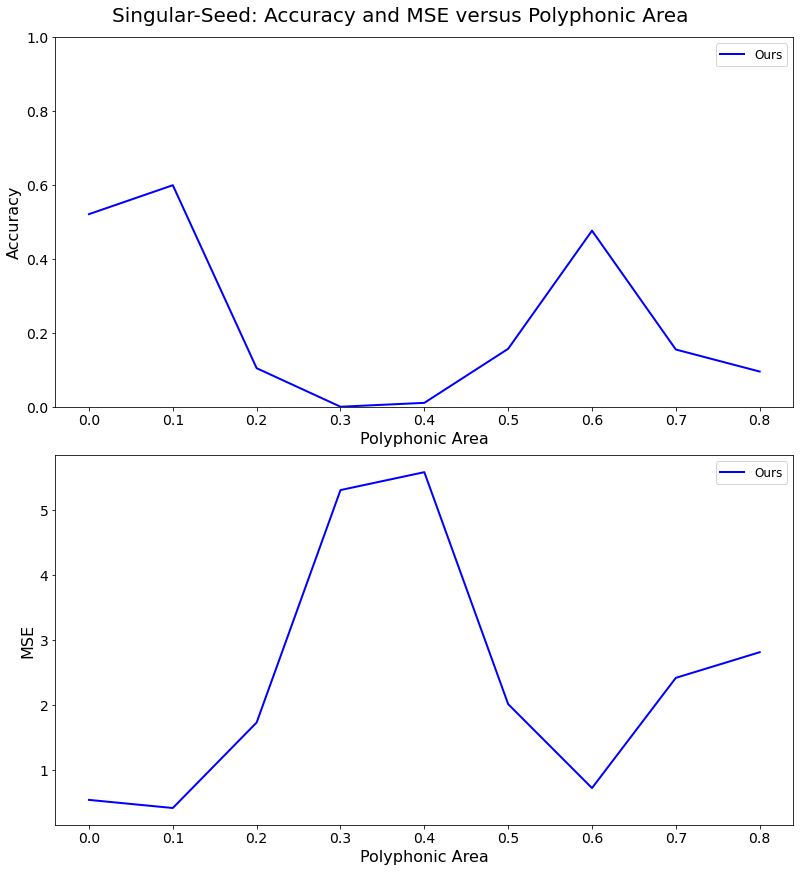

In [124]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

'''
ax[0].plot(list(PA_metric), PA_metric_acc_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PA_metric), PA_metric_acc_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[0].plot(list(PA_metric), PA_metric_acc, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Area", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

'''
ax[1].plot(list(PA_metric), PA_metric_MSE_lib, color='y', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PA_metric), PA_metric_MSE_aub, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[1].plot(list(PA_metric), PA_metric_MSE, color='b', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Area", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Singular-Seed: Accuracy and MSE versus Polyphonic Area", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'RO1-10_PA'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

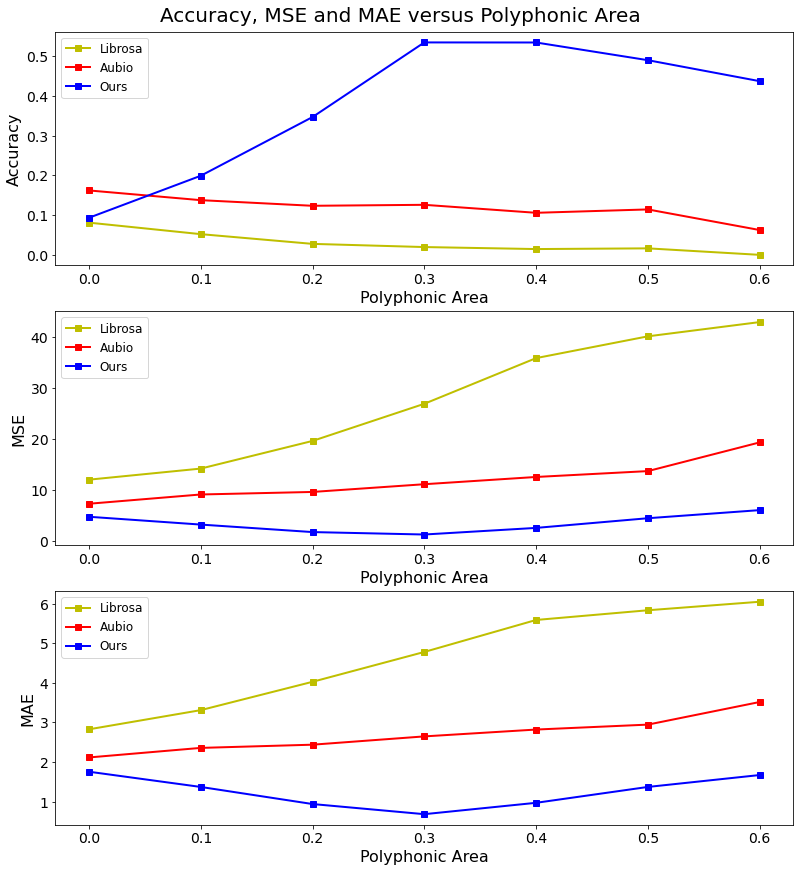

In [56]:
fig, ax = plt.subplots(3, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PA_metric), PA_metric_acc_lib, color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PA_metric), PA_metric_acc_aub, color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PA_metric), PA_metric_acc, color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Polyphonic Area", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PA_metric), PA_metric_MSE_lib, color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PA_metric), PA_metric_MSE_aub, color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PA_metric), PA_metric_MSE, color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Polyphonic Area", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

ax[2].plot(list(PA_metric), PA_metric_MDE_lib, color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[2].plot(list(PA_metric), PA_metric_MDE_aub, color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[2].plot(list(PA_metric), PA_metric_MDE, color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[2].set_xlabel("Polyphonic Area", fontsize=16)
ax[2].set_ylabel("MAE", fontsize=16)
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=14) 
ax[2].tick_params(axis="y", labelsize=14) 


fig.suptitle("Accuracy, MSE and MAE versus Polyphonic Area", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})
ax[2].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'ours_4bird', '40K_PA_epoch40_v2'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Density

In [57]:
X, Y_gt, Y_pred, _, Y_lib, Y_aub = eval_polyphony(anns, sort_attr = 'PolyphonicDensity')

Number of test samples =  7998


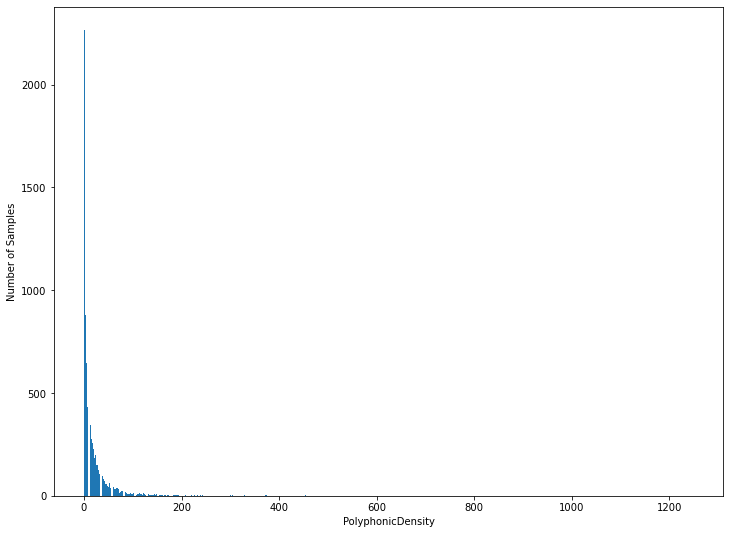

In [23]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicDensity")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

#### Since PolyphonicDensity value gets exponentially large, we consider log(PD) for evaluation

In [58]:
logX = np.log(max(X))
print("Max log(PolyphonicDensity) in the test set is ", logX)

Max log(PolyphonicDensity) in the test set is  7.129495326340208


In [59]:
PD_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    
    for idx, val in enumerate(X):
        if val > 0:
            # Decide which bin based on logX / bins
            if np.log(val) > i*logX/bins and np.log(val) <= (i/bins + 1/bins)*logX:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx])
                pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
                pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)

        PD_metric[i*logX/bins] = ([mse, mse_lib, mse_aub], [mde, mde_lib, mde_aub], [accu, accu_lib, accu_aub])

    
print(PD_metric)
PD_metric_acc = [item[2][0] for item in list(PD_metric.values())]
PD_metric_MSE = [item[0][0] for item in list(PD_metric.values())]
PD_metric_MDE = [item[1][0] for item in list(PD_metric.values())]
PD_metric_acc_lib = [item[2][1] for item in list(PD_metric.values())]
PD_metric_MSE_lib = [item[0][1] for item in list(PD_metric.values())]
PD_metric_MDE_lib = [item[1][1] for item in list(PD_metric.values())]
PD_metric_acc_aub = [item[2][2] for item in list(PD_metric.values())]
PD_metric_MSE_aub = [item[0][2] for item in list(PD_metric.values())]
PD_metric_MDE_aub = [item[1][2] for item in list(PD_metric.values())]

MSE = 4.389; MDE = 1.684; Accuracy = 11.35%
MSE = 11.739; MDE = 2.822; Accuracy = 7.57%
MSE = 7.138; MDE = 2.099; Accuracy = 16.16%
MSE = 3.189; MDE = 1.396; Accuracy = 18.90%
MSE = 14.142; MDE = 3.304; Accuracy = 5.52%
MSE = 9.461; MDE = 2.388; Accuracy = 13.73%
MSE = 2.038; MDE = 1.038; Accuracy = 31.46%
MSE = 17.522; MDE = 3.785; Accuracy = 2.77%
MSE = 9.118; MDE = 2.389; Accuracy = 12.96%
MSE = 1.263; MDE = 0.753; Accuracy = 46.67%
MSE = 24.711; MDE = 4.573; Accuracy = 2.28%
MSE = 11.000; MDE = 2.616; Accuracy = 12.93%
MSE = 1.992; MDE = 0.870; Accuracy = 51.30%
MSE = 32.406; MDE = 5.275; Accuracy = 1.38%
MSE = 11.754; MDE = 2.740; Accuracy = 10.51%
MSE = 3.336; MDE = 1.145; Accuracy = 52.30%
MSE = 36.508; MDE = 5.582; Accuracy = 2.13%
MSE = 12.913; MDE = 2.877; Accuracy = 10.63%
MSE = 3.591; MDE = 1.226; Accuracy = 49.70%
MSE = 38.637; MDE = 5.741; Accuracy = 1.52%
MSE = 13.305; MDE = 2.884; Accuracy = 12.50%
MSE = 4.611; MDE = 1.463; Accuracy = 46.30%
MSE = 39.306; MDE = 5.750; A

#### 1. Rooster-only

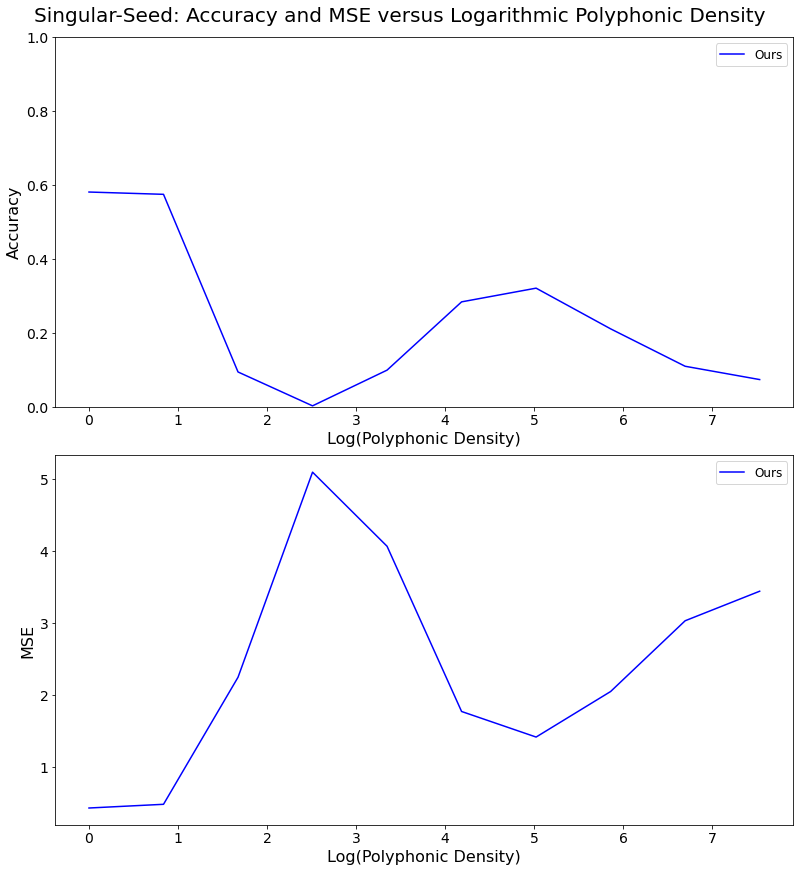

In [129]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

'''
ax[0].plot(list(PD_metric), PD_metric_acc_lib, color='y', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PD_metric), PD_metric_acc_aub, color='r', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[0].plot(list(PD_metric), PD_metric_acc, color='b', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

'''
ax[1].plot(list(PD_metric), PD_metric_MSE_lib, color='y',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PD_metric), PD_metric_MSE_aub, color='r',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
'''
ax[1].plot(list(PD_metric), PD_metric_MSE, color='b',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Singular-Seed: Accuracy and MSE versus Logarithmic Polyphonic Density", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'RO1-10_PD'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

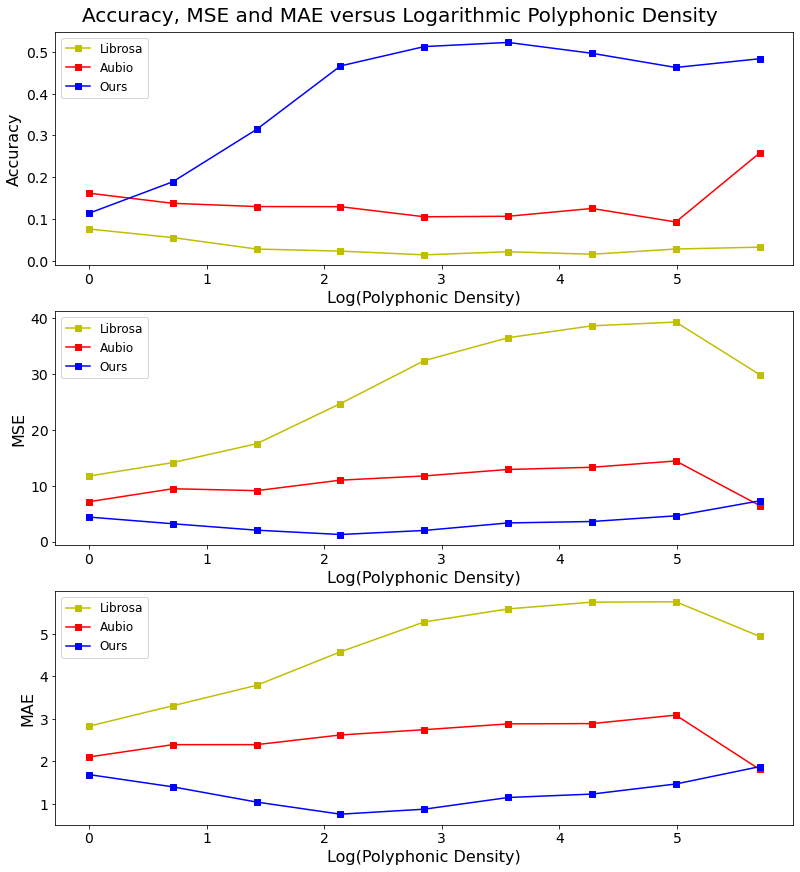

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PD_metric), PD_metric_acc_lib, color='y', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[0].plot(list(PD_metric), PD_metric_acc_aub, color='r', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[0].plot(list(PD_metric), PD_metric_acc, color='b', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[0].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PD_metric), PD_metric_MSE_lib, color='y', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[1].plot(list(PD_metric), PD_metric_MSE_aub, color='r', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[1].plot(list(PD_metric), PD_metric_MSE, color='b', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[1].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

ax[2].plot(list(PD_metric), PD_metric_MDE_lib, color='y', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa')
ax[2].plot(list(PD_metric), PD_metric_MDE_aub, color='r', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio')
ax[2].plot(list(PD_metric), PD_metric_MDE, color='b', marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Ours')
ax[2].set_xlabel("Log(Polyphonic Density)", fontsize=16)
ax[2].set_ylabel("MAE", fontsize=16)
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=14) 
ax[2].tick_params(axis="y", labelsize=14) 

fig.suptitle("Accuracy, MSE and MAE versus Logarithmic Polyphonic Density", fontsize=20)

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})
ax[2].legend(loc='best', prop={'size': 12})

fig.savefig(join('images', 'ours_4bird', '40K_PD_epoch40_v2'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()